Epoch 1/150


C:\Users\olihe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0753 - mae: 0.2454 - val_loss: 0.0076 - val_mae: 0.0702
Epoch 2/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0126 - mae: 0.0958 - val_loss: 0.0731 - val_mae: 0.2614
Epoch 3/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - mae: 0.0594 - val_loss: 0.0163 - val_mae: 0.1111
Epoch 4/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - mae: 0.0445 - val_loss: 0.0045 - val_mae: 0.0544
Epoch 5/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027 - mae: 0.0419 - val_loss: 0.0045 - val_mae: 0.0549
Epoch 6/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - mae: 0.0400 - val_loss: 0.0045 - val_mae: 0.0541
Epoch 7/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - mae: 0.0399 - val_loss: 0.0044 - val_mae: 0.0541
Epoch 8/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - mae: 0.0398 - val_loss: 0.0044 - val_mae: 0.0539
Epoch 9/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - mae: 0.

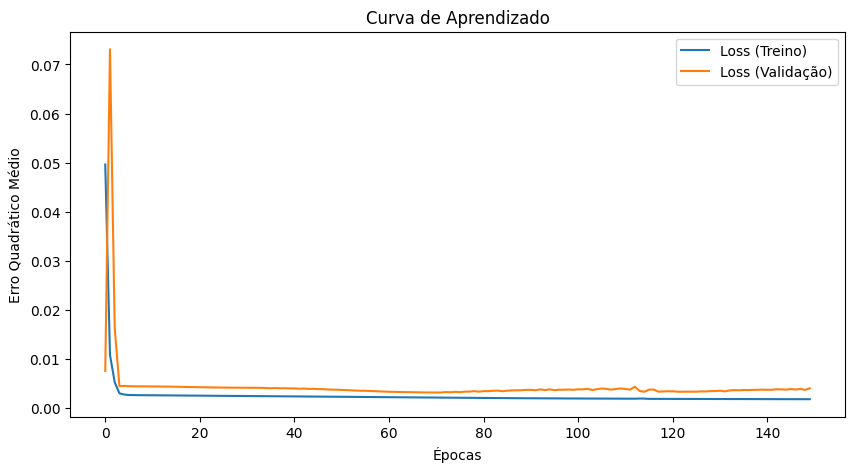

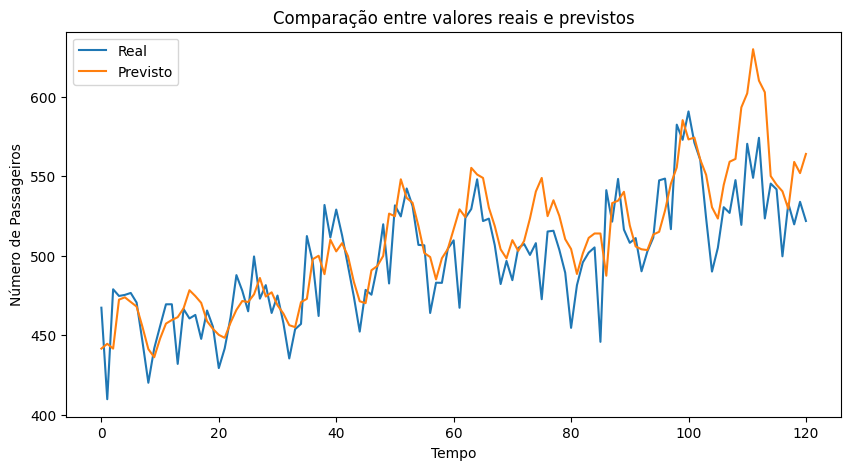

In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Garantir reprodutibilidade total
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

df = pd.read_csv('data_per_month.csv')  # Apenas a coluna de passageiros

df = df['Total Renewable Energy']
# Normalização dos dados
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values.reshape(-1, 1))

# Função para criar sequência de dados
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Definir tamanho da janela
time_steps = 12
X, y = create_sequences(data_scaled, time_steps)

# Divisão dos dados
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Construção da rede LSTM
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),
    LSTM(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Treinamento do modelo
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Avaliação do modelo
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}')

# Fazer previsões
y_pred = model.predict(X_test)

# Reverter a normalização
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Cálculo das métricas de regressão
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

# Plot da curva de aprendizado
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss (Treino)')
plt.plot(history.history['val_loss'], label='Loss (Validação)')
plt.xlabel('Épocas')
plt.ylabel('Erro Quadrático Médio')
plt.legend()
plt.title('Curva de Aprendizado')
plt.show()

# Plot dos resultados
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Real')
plt.plot(y_pred_inv, label='Previsto')
plt.xlabel('Tempo')
plt.ylabel('Número de Passageiros')
plt.legend()
plt.title('Comparação entre valores reais e previstos')
plt.show()

In [2]:
# Exibir pesos das camadas
for i, layer in enumerate(model.layers):
    print(f'Pesos da camada {i} - {layer.name}')
    weights = layer.get_weights()
    for w in weights:
        print(w.shape)  # Mostra o formato dos pesos
        print(w)  # Exibe os pesos

Pesos da camada 0 - lstm
(1, 256)
[[ 0.12882277  0.25721866 -0.02579473  0.13751228 -0.11239097  0.03639311
   0.12881859 -0.10148272  0.00540293  0.05575802 -0.13358259  0.10249727
   0.14192663  0.06340147  0.01374067  0.09930132 -0.1372163   0.38912383
   0.01831187 -0.10551755 -0.14129104  0.187597    0.15273501 -0.04108897
   0.109828   -0.11090922 -0.0115252   0.01916717  0.06532241 -0.09162746
  -0.06949611  0.56494826 -0.12657663 -0.03147396 -0.07190402 -0.07875188
   0.09871596 -0.09707351  0.05998177  0.06847728 -0.11969     0.01944646
  -0.05069074 -0.02992691  0.12832445 -0.02738267  0.00961697 -0.04288306
  -0.11527215  0.06585281  0.04505726  0.04050299 -0.1443112  -0.09512151
   0.17252423  0.11189833 -0.02084238 -0.00597657 -0.1645018  -0.14097087
   0.08381869  0.0956943  -0.02859249  0.06709456 -0.02878624 -0.10715372
  -0.03543305 -0.02338974  0.12940976  0.09734564  0.04397109  0.12128635
   0.10355906 -0.05988231  0.01842118 -0.3904125   0.13819611 -0.11540764
   0

Visualizando pesos da camada 0 - lstm


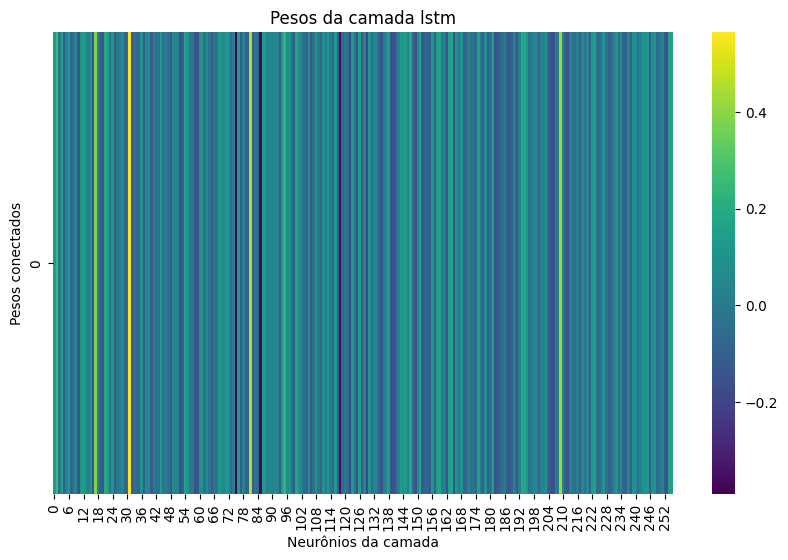

Visualizando pesos da camada 1 - lstm_1


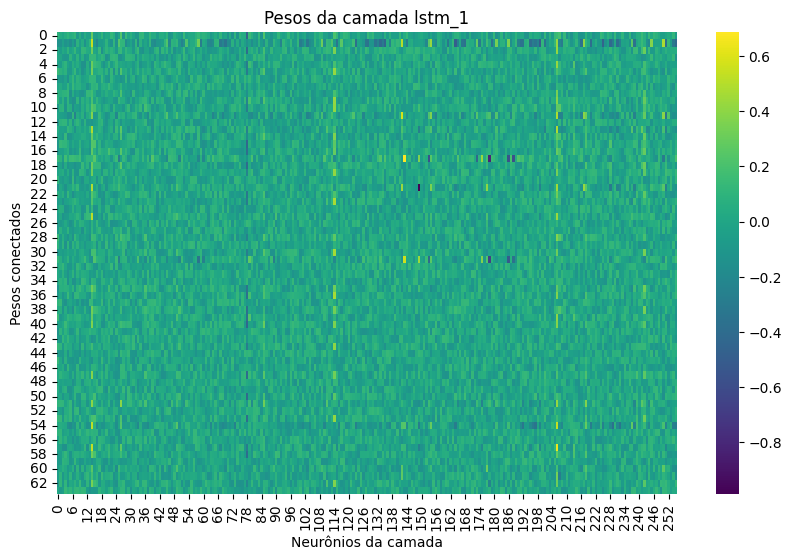

Visualizando pesos da camada 2 - dense


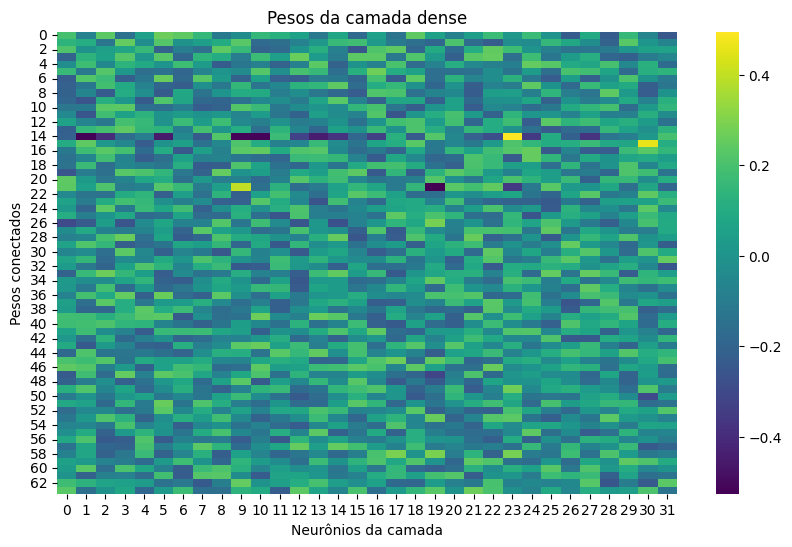

Visualizando pesos da camada 3 - dense_1


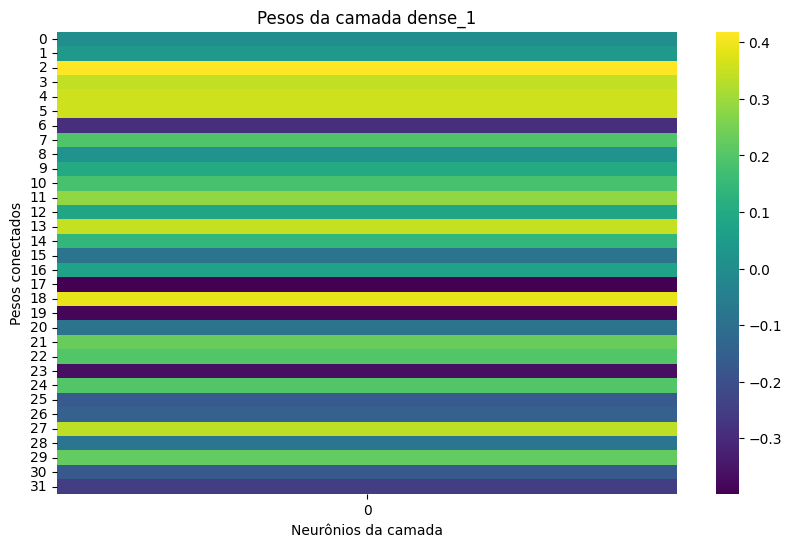

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Função para visualizar pesos de uma camada
def plot_weights(weights, title):
    plt.figure(figsize=(10, 6))
    sns.heatmap(weights, cmap="viridis", annot=False)
    plt.title(title)
    plt.xlabel("Neurônios da camada")
    plt.ylabel("Pesos conectados")
    plt.show()

# Exibir pesos das camadas LSTM
for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    if len(weights) > 0:
        print(f'Visualizando pesos da camada {i} - {layer.name}')
        plot_weights(weights[0], f'Pesos da camada {layer.name}')